# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Generate Extreme Data

In [3]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 5
ROUNDS = 5
OTHER_DATE = '2021-11-11'
_RESETS = True
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Searching for ibm_sherbrooke and 23.10.27_07h46_300pts_2std


In [4]:
# Get noise model
p1Q = 0
pZ = 0
pRE = 0
pXY = 0

p2Q = 1e-2
# pRO = 15e-2
pRO = 0


p1Q = 1e-4
p2Q = 6e-3
pXY = 1e-4
pZ = 1e-4
pRO = 1e-1
pRE = 1e-3

noise_model = simulator.get_noise_model(p1Q, p2Q, pXY, pZ, pRO, pRE)

In [11]:
SHOTS = int(1e4)
P_AMBIG = 1

extreme_IQ_data = simulator.generate_extreme_IQ(SHOTS, P_AMBIG, noise_model=None)
print(extreme_IQ_data.shape)

100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

(10000, 25)


In [27]:
simulator.generate_IQ_dict()


qubit_idx 0
grid_point_safe_0 (-0.528428093645485, 0.9966555183946486)
grid_point_ambig_0 (0.6220735785953178, -0.7157190635451505)
grid_point_safe_1 (0.6220735785953178, -0.7157190635451505)
grid_point_ambig_1 (-0.528428093645485, 0.9966555183946486)

qubit_idx 1
grid_point_safe_0 (-0.9966555183946488, 0.20735785953177244)
grid_point_ambig_0 (0.9966555183946486, -0.9966555183946488)
grid_point_safe_1 (0.9966555183946486, -0.9966555183946488)
grid_point_ambig_1 (-0.9966555183946488, 0.20735785953177244)

qubit_idx 2
grid_point_safe_0 (-0.9966555183946488, -0.8628762541806021)
grid_point_ambig_0 (0.9966555183946486, -0.8494983277591974)
grid_point_safe_1 (0.9966555183946486, -0.8494983277591974)
grid_point_ambig_1 (-0.9966555183946488, -0.8628762541806021)

qubit_idx 3
grid_point_safe_0 (-0.5016722408026757, 0.9966555183946486)
grid_point_ambig_0 (0.9966555183946486, 0.7826086956521738)
grid_point_safe_1 (0.9966555183946486, 0.7826086956521738)
grid_point_ambig_1 (-0.5016722408026757, 

{0: {'iq_point_safe_0': (-21255695.339409884-20904142.57871683j),
  'iq_point_ambig_0': (17987640.202259734-39645637.52487852j),
  'iq_point_safe_1': (17987640.202259734-39645637.52487852j),
  'iq_point_ambig_1': (-21255695.339409884-20904142.57871683j)},
 1: {'iq_point_safe_0': (-2371079.9779586853-2118608.112790446j),
  'iq_point_ambig_0': (2169563.116658685-3517911.5496523734j),
  'iq_point_safe_1': (2169563.116658685-3517911.5496523734j),
  'iq_point_ambig_1': (-2371079.9779586853-2118608.112790446j)},
 2: {'iq_point_safe_0': (-3410137.719392624-2993290.7645704304j),
  'iq_point_ambig_0': (2777688.9133926234-2975909.1178212767j),
  'iq_point_safe_1': (2777688.9133926234-2975909.1178212767j),
  'iq_point_ambig_1': (-3410137.719392624-2993290.7645704304j)},
 3: {'iq_point_safe_0': (-1436038.5779911235-1413310.9979008324j),
  'iq_point_ambig_0': (2538689.041950364-1570187.6151462914j),
  'iq_point_safe_1': (2538689.041950364-1570187.6151462914j),
  'iq_point_ambig_1': (-1436038.577991

# Get counts from IQ data

In [12]:
import cpp_soft_info

print(cpp_soft_info.get_counts(extreme_IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))

{'00000 1111 1111 1111 1111 1111': 10000}


# Decode IQ data

In [13]:
import pymatching
import stim


circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=p2Q, #two-qubit-fidelity,
                                after_reset_flip_probability=pRE, #reset error,
                                before_measure_flip_probability=pRO, #measurement error,
                                before_round_data_depolarization=(pXY+pZ)/2) #idle error)
# print(circuit)

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

P_DATA = 1e-2
P_MIXED = 1e-2
P_MEAS = P_AMBIG

In [20]:
import cpp_soft_info

matching = pymatching.Matching.from_detector_error_model(model)
# cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _bimodal=True, merge_strategy = "replace", _detailed=True)
print("num_errors:", result.num_errors, "out of", len(extreme_IQ_data), "shots")

num_errors: 0 out of 10000 shots


In [21]:
matching = pymatching.Matching.from_detector_error_model(model)
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=True)
print("num_errors:", result_flat.num_errors, "out of", len(extreme_IQ_data), "shots")


num_errors: 0 out of 10000 shots


In [22]:
matching = pymatching.Matching.from_detector_error_model(model)

p_meas = P_MEAS
# p_meas = 0e-2

result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, extreme_IQ_data, 
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = -1, common_measure=-1, _detailed=True)

print("num_errors:", result_informed.num_errors, "out of", len(extreme_IQ_data), "shots")
         
# takes 1s

num_errors: 0 out of 10000 shots


# Plot the results

In [23]:
print("\nIQ:", result.indices, "\nFlat:", result_flat.indices, "\nInformed", result_informed.indices)


IQ: [] 
Flat: [] 
Informed []


-----IQ-----


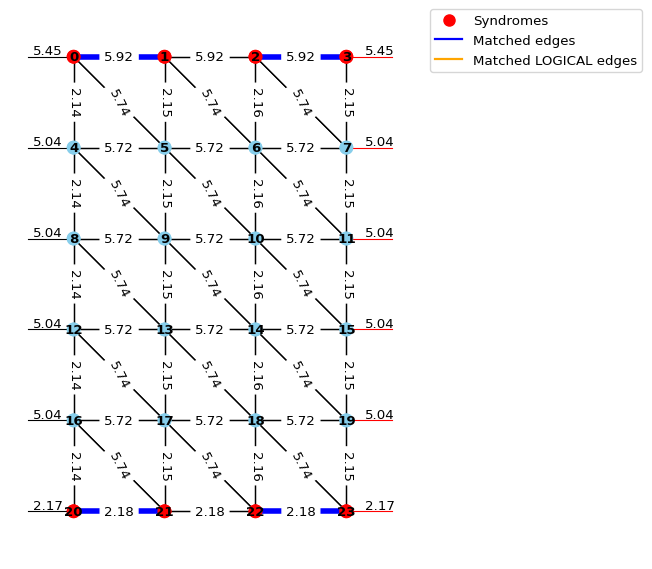

-----flat-----


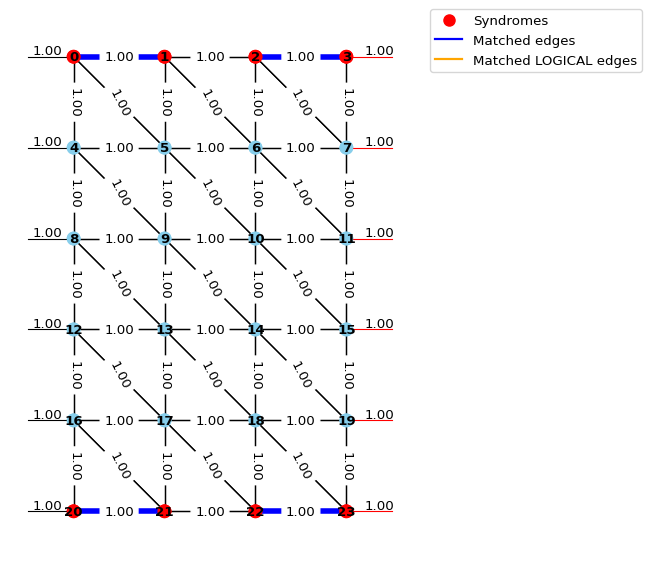

-----INFORMED-----


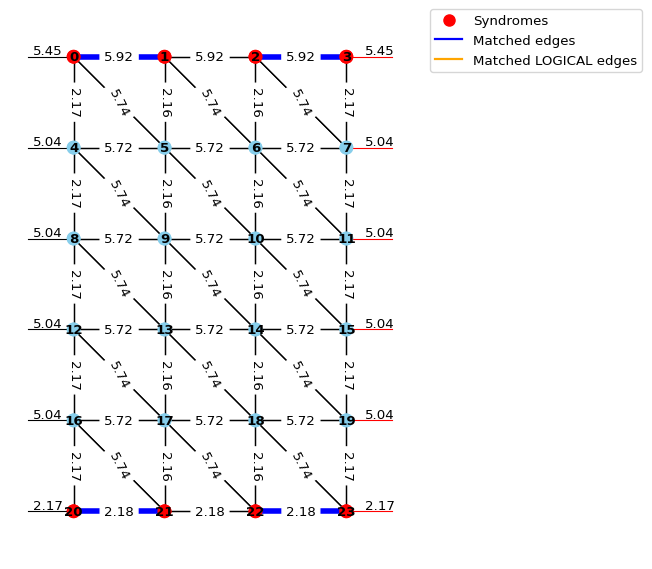

In [24]:
from soft_info import draw_matching_graph


index = 100

fig_size = (4, 13)
scale_factor = 0.8

to_be_result = result
details = to_be_result.error_details[index]
print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_flat
details = to_be_result.error_details[index]
print("-----flat-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_informed
details = to_be_result.error_details[index]
print("-----INFORMED-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [26]:
# print the differences between the two lists using sets
print("diff between IQ and informed:")
print(set(result_informed.indices) - set(result.indices))
print(set(result.indices) - set(result_informed.indices))

print()
print("diff between flat and informed:")
print(set(result.indices) - set(result_flat.indices))
print(set(result_flat.indices) - set(result.indices))



diff between IQ and informed:
set()
set()

diff between flat and informed:
{4262, 8551, 9257, 7723, 9836, 6891, 8974, 6930, 3800, 7452}
{9217, 5142, 7705, 5159, 4135, 8746, 9259, 9260, 9261, 5176, 8778, 6734, 4704, 4705, 6755, 6757, 8806, 6759, 5745, 8307, 3703, 9848, 5241, 8826, 8827, 4221, 6283, 9870, 7827, 6805, 8341, 7320, 8856, 9882, 7838, 1186, 8355, 7855, 6326, 8888, 7868, 9926, 7372, 9933, 6358, 6881, 6882, 7395, 8426, 6379, 9452, 5870, 6388, 9977, 9467, 9979, 4864, 6408, 9998, 3858, 5395, 7956, 9507, 8489, 5931, 6969, 4417, 4418, 5447, 1867, 1868, 8524, 4431, 8020, 9048, 8026, 9052, 9054, 9060, 5477, 5481, 6519, 6016, 8081, 7065, 7066, 7067, 8091, 8096, 9634, 6052, 8112, 5051, 5052, 8637, 4573, 9192, 5614, 7664, 9207, 9208}
